In [1]:
import os
import uuid

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import uuid
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from HiDDeN import HiDDeN

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
datadir = './data/voc'
trainingset = datadir + '/train/'
testset = datadir + '/tester/'

BATCH_SIZE = 20
KERNEL_SIZE = 3
IMAGE_SIZE = 128
CHANNEL = 3

EVAL_STEP = 5
MAX_EPOCHS = 100

In [3]:
def unique(list1):
	# insert the list to the set
	list_set = set(list1)
	# convert the set to the list
	unique_list = (list(list_set))
	res = []
	for x in unique_list:
		res.append(x)
	return res


def string_to_binary(string):
	binary_message = ''.join(format(i, '08b') for i in bytearray(string, encoding ='utf-8'))
	return binary_message


def generate_random_messages(N):
	message_string = []
	messages_binary = []
	messages_tensor = None
	for _ in range(N):
		text = uuid.uuid4().hex
		binary_message = string_to_binary(text)
		message_array = [float(x) for x in binary_message]
		message_ts = tf.constant(message_array)
		message_ts = tf.reshape(message_ts, (16,16,1))
		message_ts = tf.expand_dims(message_ts, axis=0)
		
		message_string.append(text)
		messages_binary.append(message_array)
		if messages_tensor is None:
			messages_tensor = message_ts
		else:
			messages_tensor = tf.concat([messages_tensor, message_ts], axis=0)

	return (message_string, tf.constant(messages_binary), messages_tensor)


def decode_binary_string(s):
    byte_string = ''.join(chr(int(s[i*8:i*8+8],2)) for i in range(len(s)//8))
    return byte_string.encode().decode('utf-8')


def round_predicted_message(predicted_message):
    rounded_message = ''
    for num in predicted_message:
        if(float(num) > 0.5):
            rounded_message += '1'
        else:
            rounded_message += '0'
    return rounded_message


def count_errors(original_message, predicted_message):
    original_message = round_predicted_message(original_message)
    count = 0
    for i in range(len(original_message)):
        if original_message[i] != predicted_message[i]:
            count += 1
    return count

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [5]:
train_generator = train_datagen.flow_from_directory(
		directory=trainingset,
		target_size=(IMAGE_SIZE, IMAGE_SIZE),
		color_mode="rgb",
		batch_size=BATCH_SIZE,
		class_mode="input",
		shuffle=False
	)

Found 20 images belonging to 1 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
		directory=testset,
		target_size=(IMAGE_SIZE, IMAGE_SIZE),
		color_mode="rgb",
		batch_size=BATCH_SIZE,
		class_mode="input",
		shuffle=False,
	)

Found 20 images belonging to 1 classes.


In [7]:
(msg_str_train, msg_array_train, msg_tensor_train) = generate_random_messages(train_generator.n)
len(unique(msg_str_train)) == len(msg_str_train)

True

In [8]:
(msg_str_test, msg_array_test, msg_tensor_test) = generate_random_messages(2) #test_generator.n
len(unique(msg_str_test)) == len(msg_str_test)

True

In [9]:
print(f"Image input {train_generator.image_shape}")
print(f'Loaded {train_generator.n} training samples')
print(f'Loaded {test_generator.n} test samples')

Image input (128, 128, 3)
Loaded 20 training samples
Loaded 20 test samples


In [10]:
input_shape = train_generator.image_shape
L = msg_array_train.shape[1]
(N, H, W, C) = (train_generator.n, input_shape[0], input_shape[1], input_shape[2])
(N, H, W, C)

(20, 128, 128, 3)

In [11]:
print(f'{N} images, {H} x {W} x {C}')
print(f"Message length: {L}")

20 images, 128 x 128 x 3
Message length: 256


In [12]:
model = HiDDeN(
	img_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL), 
	msg_shape=(msg_tensor_train.shape[1],msg_tensor_train.shape[2], msg_tensor_train.shape[3]),
	kernel_size=KERNEL_SIZE,
	)

In [13]:
train_msg_set = (msg_str_train, msg_array_train, msg_tensor_train)
test_msg_set = (msg_str_test, msg_array_test, msg_tensor_test)

In [14]:
generator = model.Generator()
discriminator = model.Discriminator()
reader = model.Reader()

generator_loss = model.generator_loss
discriminator_loss = model.discriminator_loss

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)
reader_optimizer = Adam(2e-4, beta_1=0.5)
		

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
                        generator_optimizer=generator_optimizer,
                        discriminator_optimizer=discriminator_optimizer,
                        reader_optimizer=reader_optimizer,
                        generator=generator,
                        discriminator=discriminator,
                        reader=reader,
            )

log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
	log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [32]:
def generate_images(img_model, msg_model, input_img, input_msg, target_msg, target_str):
    img_pred = img_model([tf.constant(input_img), input_msg], training=True)
    msg_pred = msg_model(img_pred, training=True)

    original_message = round_predicted_message(target_msg)
    predicted_message = round_predicted_message(msg_pred[0])
    predicted_message_str = decode_binary_string(predicted_message)
    
    print("Original message as String: ", target_str)
    print("Predicted message as String: ", predicted_message_str)
    print("Original message in Binary: ", original_message)
    print("Predicted message in Binary: ", predicted_message)
    errors = count_errors(original_message, predicted_message)
    print(f'Errors {errors}/{256}')

    plt.figure(figsize=(15, 15))
    display_list = [(input_img[0]*255).astype(np.uint8), (img_pred[0].numpy()*255).astype(np.uint8)]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

In [27]:
import numpy as np

Original message as String:  2ae19d950ff64124818efb75b54bbd20
Predicted message as String:      @        @               
Original message in Binary:  0011001001100001011001010011000100111001011001000011100100110101001100000110011001100110001101100011010000110001001100100011010000111000001100010011100001100101011001100110001000110111001101010110001000110101001101000110001001100010011001000011001000110000
Predicted message in Binary:  0000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000100000000000000000000000000000000000000000010000000000000000000000000000000000000000000000001000000000000000000000000
Errors 108/256


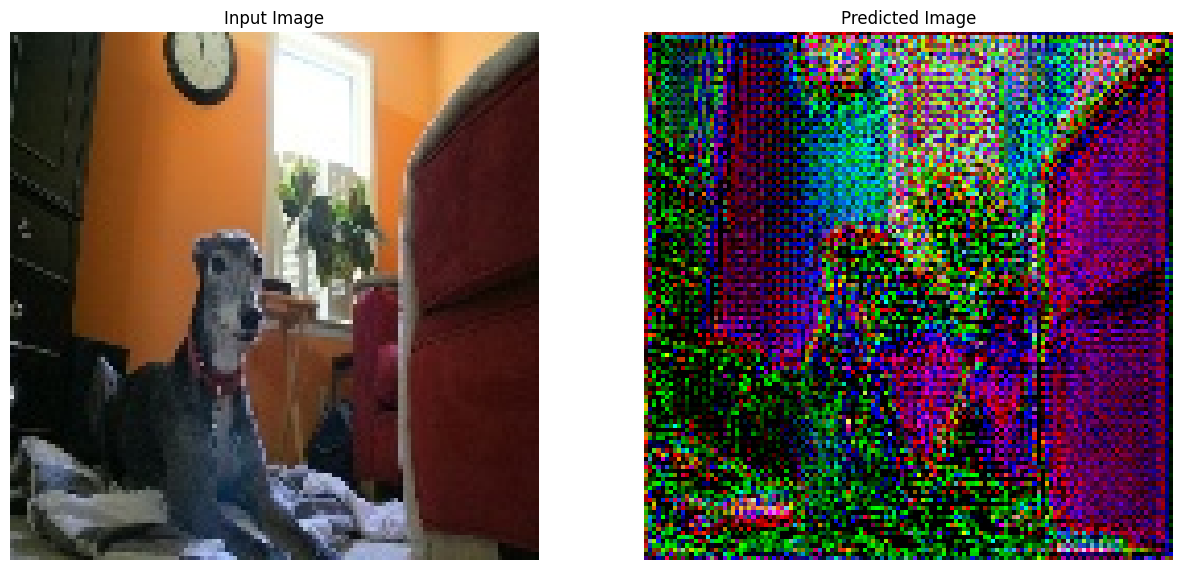

In [33]:
generate_images(
    generator, 
    reader, 
    test_generator[0][0][:1], 
    msg_tensor_test[:1],
    msg_array_test[0],
    msg_str_test[0],
    )

In [18]:
@tf.function
def train_step(input_image, input_msg, target_msg, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as read_tape:
        gen_output = generator([input_image, input_msg], training=True)

        disc_real_output = discriminator([input_image, input_image], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
          
        reader_output = reader(gen_output, training=True)

        gen_total_loss, gen_reader_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, 
            gen_output, 
            input_image, 
            reader_output, 
            target_msg)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        reader_loss = discriminator_loss(target_msg, reader_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)
	
    reader_gradients = read_tape.gradient(
        reader_loss,
        reader.trainable_variables,
    )

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))
    reader_optimizer.apply_gradients(zip(reader_gradients,
                                        reader.trainable_variables))
    if step == BATCH_SIZE-1:
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
            tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
            tf.summary.scalar('gen_reader_loss', gen_reader_loss, step=step)
            tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
            tf.summary.scalar('disc_loss', disc_loss, step=step)
            tf.summary.scalar('reader_loss', reader_loss, step=step)

In [34]:
def fit(
    train_img_ds, 
    train_msg_ds, 
    test_img_ds, 
    test_msg_ds,
    max_epoch,
) -> None:
    
    for epoch in tqdm(range(max_epoch)):
        #TRAINING
        print("TRAINING EPOCH", epoch)
        for idx_batch in tqdm(range(len(train_img_ds))):
            input_img = train_img_ds[idx_batch][0]
            input_msg = train_msg_ds[2][idx_batch * BATCH_SIZE : idx_batch * BATCH_SIZE + BATCH_SIZE]
            target_msg = train_msg_ds[1][idx_batch * BATCH_SIZE : idx_batch * BATCH_SIZE + BATCH_SIZE]
            
            train_step(input_img, input_msg, target_msg, idx_batch)
    
        #VALIDATION
        if epoch%EVAL_STEP == 0:
            clear_output()
            print("VALIDATION EPOCH", epoch)
            generate_images(
                generator, 
                reader, 
                test_img_ds[0][0][:1], 
                test_msg_ds[2][:1],
                test_msg_ds[1][0],
                test_msg_ds[0][0],
                )
            
            checkpoint.save(file_prefix=checkpoint_prefix)

VALIDATION EPOCH 5
Original message as String:  2ae19d950ff64124818efb75b54bbd20
Predicted message as String:      @                           
Original message in Binary:  0011001001100001011001010011000100111001011001000011100100110101001100000110011001100110001101100011010000110001001100100011010000111000001100010011100001100101011001100110001000110111001101010110001000110101001101000110001001100010011001000011001000110000
Predicted message in Binary:  0000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Errors 108/256


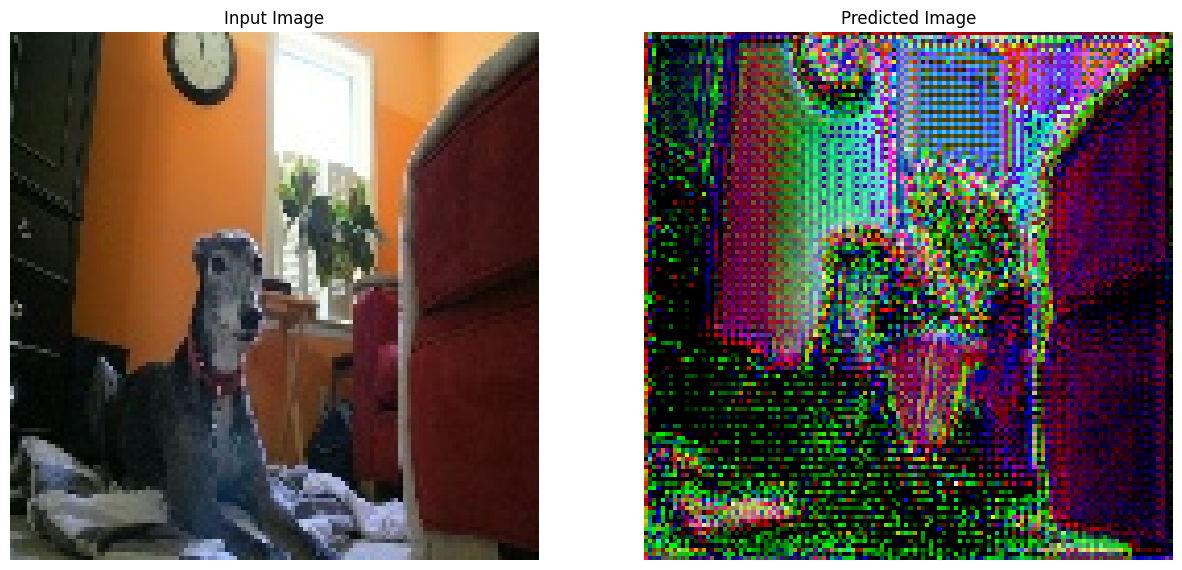

In [35]:
fit(train_generator, train_msg_set, test_generator, test_msg_set, MAX_EPOCHS)